In [1]:
import numpy as np
import seaborn as sns
from time import time

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.regularizers import L1L2
import keras.backend as K

import os
import gc
from pathlib import Path

# tf.config.experimental.set_visible_devices([], 'GPU')

Using TensorFlow backend.


In [2]:
init_state = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

In [3]:
class Game:
    def __init__(self, state, FIRST):
        self.state = state
        self.empty = self.make_empty(state)
        self.first_player = FIRST
        
    def make_empty(self, state):
        emp = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == 0:
                    emp.append(3*i + j)
        
        return emp
    
    def is_lose(self, a):
        opp = 2 - (a-1)
        
        for i in range(3):
            if self.state[i][0] == self.state[i][1] == self.state[i][2] == opp:
                return True
            elif self.state[0][i] == self.state[1][i] == self.state[2][i] == opp:
                return True
        if self.state[0][0] == self.state[1][1] == self.state[2][2] == opp:
            return True
        if self.state[0][2] == self.state[1][1] == self.state[2][0] == opp:
            return True
        return 0
    
    def is_win(self, a):       
        for i in range(3):
            if self.state[i][0] == self.state[i][1] == self.state[i][2] == a:
                return True
            elif self.state[0][i] == self.state[1][i] == self.state[2][i] == a:
                return True
        if self.state[0][0] == self.state[1][1] == self.state[2][2] == a:
            return True
        if self.state[0][2] == self.state[1][1] == self.state[2][0] == a:
            return True
        return False
    
    def is_draw(self, a):
        if self.is_win(a):
            return 0
        if np.all(self.state):
            return 1
        else:
            return 0
        
    def is_done(self):
        if self.is_win(1) or self.is_win(2) or self.is_draw(1) or self.is_draw(2):
            return 1
        else:
            return 0
        
        
    def update(self, target):
        state = self.state.copy()
        x, y = target//3, target%3
        a = self.next_opp()
        state[x][y] = a
        return Game(state, self.first_player)
    
    
    def next_opp(self):
        a = b = 0
        for i in range(len(self.state)):
            for j in range(len(self.state)):
                if self.state[i][j] == self.first_player:
                    a += 1
                elif self.state[i][j] != 0:
                    b += 1
                    
        if a == b:
            return self.first_player
        else:
            return 2 + min(0, 1-self.first_player)

In [4]:
class Random:
    def __init__(self, status):
        self.status = status

    def action(self, game):
        return np.random.choice(game.empty)

In [31]:
status = 1




# def action(game):
#     values = [0] * len(game.empty)

#     for i, a in enumerate(game.empty):
#         for _ in range(100):
#             g = game.update(a)
#             values[i] += playout(g)

#     return game.empty[np.argmax(values)]

In [39]:
DN_FILTERS = 64 #초기 노드 수
DN_RESIDUAL_NUM = 3  # 중간노드
DN_OUTPUT_SIZE = 9  # 행동 수(배치 수(3*3))
    
def make_model():
    inputs = layers.Input(shape = (9, ))
    x = layers.Dense(DN_FILTERS)(inputs)
    for i in range(DN_RESIDUAL_NUM):
        x = layers.Dense(DN_FILTERS//2, kernel_initializer='he_normal', kernel_regularizer=L1L2(l2=0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
    outputs = layers.Dense(DN_OUTPUT_SIZE, activation='softmax', kernel_regularizer=L1L2(l2=0.001))(x)
    m = models.Model(inputs, outputs)
    m.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy')
    
    return m

class DQN:
    def __init__(self, status):
        K.clear_session()
        self.model = make_model()
        self.status = status
        
    def action(self, game):
        status = game.next_opp()
        target = self.make_state(game)       
        res = self.model.predict(target)[0]
        a = np.argmax(res)
        while a not in game.empty:
            res[a] = -float('inf')
            a = np.argmax(res)
        return a
    
    def playout(self, game):
        status = self.status
        if game.is_lose(status):
            return -1

        if game.is_draw(status):
            return 0


        if game.is_win(status):
            return 1

        return self.playout(game.update(np.random.choice(game.empty)))
    
    def value(self, game):
        values = [0] * 9
        n_steps = 20

        for i in range(9):
            if i in game.empty:
                for _ in range(n_steps):
                    g = game.update(i)
                    values[i] += playout(g)
            values[i] /= n_steps
            
        return values

    def train(self):
        GAMMA = 0.95
        for i in [1, 2]:
            game = Game(init_state, i)
            memory = []
            while 1:
                status = game.next_opp()
                state = self.make_state(game)
                

                a = self.action(game)
                
                if game.is_win(status):
                    r = 1
                    state_next = np.zeros(9)
                else:
                    r = 0
                    state_next = self.make_state(game.update(a))
                v = self.value(game)
                memory.append((state, a, r, v, state_next))
                
                game = game.update(a)
                if game.is_done():
                    break    
                
            inputs = np.zeros((len(memory), 9))
            targets = np.zeros((len(memory), 9))
            for j, (state, a, r, v, state_next) in enumerate(memory):
                inputs[j] = state
                if (state_next == np.zeros(9)).all():
                    target = r
                else:
                    target = r + GAMMA * np.argmax(self.model.predict(state_next)[0])
                
#                 targets[j] = v
                targets[j][a] += target

            self.model.fit(inputs, targets, epochs=1, verbose=0)
                
    
    def opp(self, status):
        return 2 + min(0, 1-status)
    
    def make_state(self, game):
        state = np.reshape(game.state, (1, 9))
        state = np.where(state==game.next_opp(), 1, np.where(state==0, 0, -1))
        return state

In [40]:
dd = DQN(1)

In [41]:
dd.train()

In [42]:
for _ in range(1000):
#     print(_)
    dd.train()
    
# dd.model.save('./dqn500.h5')

In [ ]:
a = init_state.copy()
a = np.reshape(a, (1, 1, 3, 3)).astype('float')
a = np.where(a==1, 1., np.where(a==0, 0, -1.))

dd.model.predict(a)


In [ ]:
gc.collect()

In [ ]:
# def train(game):
#     global X, y

#     while 1:
#         X.append(np.reshape(game.state, (1, 3, 3)))
#         a1 = action(game)
#         game = game.update(a1)
#         temp_y = [0] * 9
#         temp_y[a1] = 1
#         y.append(temp_y)
    
#         if game.is_win(1):
#             break 
#         elif game.is_draw(1):
#             break 

#         a2 = np.random.choice(game.empty)
#         game = game.update(a2)
#         if game.is_win(2):
#             y *= -1
#             break 
#         elif game.is_draw(2):
#             break
        
#     X = np.reshape(X, (len(X), 1, 3, 3))
#     if len(y) == 0:
#         print('pass')
#         return
#     y = np.reshape(y, (len(X), 9))   

#     k.model.fit(X, y, epochs=1, verbose=0)
# #     return model

In [ ]:
# %%time
# # train n_steps
# FIRST = 1
# k = DQN(1)
# # model = k.model
# g = Game(init_state)
# n_steps = 500
# for _ in range(n_steps):
#     X = []
#     y = []
#     train(g)
#     gc.collect()
#     del X, y

In [12]:
def play(game, m1, m2):
    global score
    while 1:
        a1 = m1.action(game)
        game = game.update(a1)
        if game.is_win(m1.status):
            score[m1.status-1] += 1
            return 
        elif game.is_draw(m1.status):
            score[2] += 1
            return 

        a2 = m2.action(game)
        game = game.update(a2)
        if game.is_win(m2.status):
            score[m2.status-1] += 1
            return 
        elif game.is_draw(m2.status):
            score[2] += 1
            return 
        

In [14]:
dd.status

1

In [43]:
%%time

m1 = Random(2)
score = [0, 0, 0]

game = Game(init_state, 1)
for _ in range(100):
    print(_)
    play(game, dd, m1)
    
gc.collect()

game = Game(init_state, 2)
score1 = score.copy()
for _ in range(100):
    print(_)
    play(game, m1, dd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Wall time: 1.39 s


In [44]:
score

[100, 45, 55]

In [45]:
score1

[60, 11, 29]

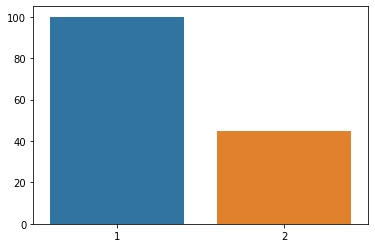

In [46]:
sns.barplot(x = [1, 2], y = score[:2])

In [ ]:
# tanh + mse
# v1: 732vs601 // 350vs323
# v2: 738vs399 // 411vs149
# v3: 1161vs773 // 791vs170
# v4: 1305vs567 // 832vs86

In [25]:
state = np.reshape(game.state, (1, 9))
state = np.where(state==game.next_opp(), 1, np.where(state==0, 0, -1))
dd.model.predict(state)

array([[2.3473647e-11, 9.8615474e-01, 1.0090507e-02, 1.7726414e-03,
        3.9066803e-09, 4.5363063e-06, 1.9776151e-03, 1.2000709e-09,
        2.7990125e-12]], dtype=float32)

In [26]:
dd.make_state(g)

NameError: name 'g' is not defined

In [27]:
g = game.update(4)
print(g.state)

[[0 0 0]
 [0 2 0]
 [0 0 0]]


In [ ]:
g = g.update(2)

In [ ]:

g.state